# Summary

This notebook centers on predicting the maximum depth of anomalies in In-Line Inspection (ILI) data. Utilizing various machine learning techniques, the goal is to fill in missing values and forecast the future growth of anomalies. Accurately estimating anomaly depth is critical for assessing pipeline strength and ensuring safety. The process involves data exploration, cleaning, feature engineering, anomaly mapping, and advanced modeling. These steps offer valuable insights for managing pipeline integrity, enabling proactive maintenance and risk mitigation.

The ILI data for this study is publicly available from the [Mendeley Data repository](https://data.mendeley.com/datasets/c2h2jf5c54/1). The dataset, titled "Dataset for: Cross-country Pipeline Inspection Data Analysis and Testing of Probabilistic Degradation Models", was published on October 4, 2021, by Rioshar Yarveisy, Faisal Khan, and Rouzbeh Abbassi from Memorial University of Newfoundland and Macquarie University. The dataset includes four consecutive ILI data sets, which lack certain details such as coordinates, likely due to anonymization efforts.

# Introduction

Pipeline integrity management is crucial in ensuring the safety and reliability of gas and oil transportation. In-line inspection (ILI) tools are extensively used to detect and measure anomalies in pipelines. Accurately predicting the maximum depth of these anomalies is essential for proactive maintenance and risk mitigation. This notebook demonstrates a comprehensive workflow, from data loading and cleaning to advanced machine learning modeling, aimed at predicting anomaly depths effectively. Key steps in the process include:

**Data Exploration and Cleaning**: This involves exploratory data analysis (EDA) to understand the data distribution and identify patterns, handling duplicate records, and managing missing values.

**Feature Engineering**: We compute new features such as aspect ratio and area of anomalies, estimate the maximum depth using domain-specific calculations, and create cyclic features from angular measurements.

**Anomaly Mapping**: We match anomalies across different inspection years to track their growth and changes over time. This involves sophisticated matching algorithms to identify corresponding anomalies based on relative distances and orientations.

**Modeling**: We employ machine learning models, particularly the Hist Gradient Boosting Regressor, to predict the maximum depth of anomalies. This includes data preparation, model training, hyperparameter tuning, and evaluation.

**Prediction and Validation**: The predicted values are validated against actual measurements to ensure accuracy. We also compare the machine learning predictions with domain-specific estimates to highlight the added value of advanced modeling techniques.

The ILI data for this study is publicly available from the [Mendeley Data repository](https://data.mendeley.com/datasets/c2h2jf5c54/1). The dataset, titled "Dataset for: Cross-country Pipeline Inspection Data Analysis and Testing of Probabilistic Degradation Models," was published on October 4, 2021, by Rioshar Yarveisy, Faisal Khan, and Rouzbeh Abbassi from Memorial University of Newfoundland and Macquarie University. The dataset includes four consecutive ILI data sets, which lack certain details such as coordinates, likely due to anonymization efforts.

# Setup

## Import Dependencies

In [2]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import importlib
from src import tools
importlib.reload(tools)

<module 'src.tools' from 'c:\\Users\\Farhad.Davaripour\\Repositories\\AI_Applications_in_Pipeline_Engineering\\src\\tools.py'>

In [ ]:
# Set the directory to save and read the data
save_path = "../Dataset/processed_data/"

## Loading the ILI Data

In [109]:
AnomaliesProc  = pd.read_csv(os.path.join(save_path, f'external_anomoly_processed.csv'))

### Rename Columns

In [53]:
from src.tools import rename_anomaly_columns

# Rename the columns
AnomaliesProc = rename_anomaly_columns(AnomaliesProc)

# Data Exploration and Cleaning

## EDA

In [3]:
from src.tools import EDA

### Max Depth (mm)

In [ ]:
# Create the EDA object
eda = EDA(AnomaliesProc)

In [ ]:
# plot the histogram of the max depth
eda.plot_histogram_max_depth('MaxDepth_mm')

In [ ]:
# Summary statistics
print(AnomaliesProc['MaxDepth_mm'].describe())

In [ ]:
# Calculate the percentiles and IQR
eda.calculate_percentiles_and_iqr('MaxDepth_mm')

In [ ]:
# Plot the boxplot
eda.plot_boxplot_max_depth('MaxDepth_mm')

### Linear Correlation

In [ ]:
eda.plot_correlation_matrix()

## Duplicate Values

In [54]:
# Check for duplicate rows
duplicates = AnomaliesProc.duplicated(keep=False)

# Display the duplicate rows
duplicate_rows = AnomaliesProc[duplicates]

# Print the duplicate rows
print("Duplicate rows in the dataframe:")
print(duplicate_rows)

Duplicate rows in the dataframe:
Empty DataFrame
Columns: [InspectionYear, GirthWeldNumber, JointLength_m, RelativeDistance_m, SeamOrientation_deg, StartPointDistance_m, StartPointOrientation_deg, EndPointDistance_m, EndPointOrientation_deg, SignificantPointRelDistance_m, SignificantPointOrientation_deg, WallThickness_mm, FeatureLength_mm, FeatureWidth_mm, MaxDepth_mm]
Index: []


## Missing Values

In [55]:
from src.tools import MissingValuesAnalyzer

# Create the MissingValuesAnalyzer object
MissingValuesAnalyzer = MissingValuesAnalyzer(AnomaliesProc)

### Identify Features w/ Missing Values

In [56]:
# Find columns with missing values
MissingValuesAnalyzer.find_missing_values()

Columns with missing values:
SeamOrientation_deg: 845310
EndPointDistance_m: 759683


### End Point Distance                 

In [57]:
# Apply the calculation only if the 'EndPointDistance_m' column has NaN values
AnomaliesProc['EndPointDistance_m'] = np.where(
    AnomaliesProc['EndPointDistance_m'].isna(),
    AnomaliesProc['StartPointDistance_m'] + AnomaliesProc['FeatureLength_mm'] / 1000,
    AnomaliesProc['EndPointDistance_m']
)

In [58]:
# Find the remaining columns with missing values
MissingValuesAnalyzer.find_missing_values()

Columns with missing values:
SeamOrientation_deg: 845310


### Seam Orientation             

### Handle Joints with Inconsistent Seam Orientation

In [59]:
# Handle joints with inconsistent seam orientation
MissingValuesAnalyzer.check_inconsistent_seam_orientation()


GirthWeldNumber 32:
  InspectionYear 1:
SeamOrientation_deg
0.0    12
  InspectionYear 3:
Series([], )
  InspectionYear 5:
SeamOrientation_deg
360.0    12
  InspectionYear 7:
SeamOrientation_deg
360.0    12

GirthWeldNumber 73:
  InspectionYear 1:
SeamOrientation_deg
38.0    2
  InspectionYear 3:
Series([], )
  InspectionYear 5:
SeamOrientation_deg
28.0    2
  InspectionYear 7:
SeamOrientation_deg
28.0    2

GirthWeldNumber 74:
  InspectionYear 1:
SeamOrientation_deg
24.0    4
  InspectionYear 3:
Series([], )
  InspectionYear 5:
SeamOrientation_deg
14.0    2
  InspectionYear 7:
SeamOrientation_deg
14.0    2

GirthWeldNumber 77:
  InspectionYear 1:
SeamOrientation_deg
52.0    16
  InspectionYear 3:
Series([], )
  InspectionYear 5:
SeamOrientation_deg
38.0    13
  InspectionYear 7:
SeamOrientation_deg
38.0    19

GirthWeldNumber 81:
  InspectionYear 1:
SeamOrientation_deg
36.0    8
  InspectionYear 3:
Series([], )
  InspectionYear 5:
SeamOrientation_deg
20.0    5
  InspectionYear 7:
Sea

In [60]:
# Handle joints with inconsistent seam orientation
MissingValuesAnalyzer.handle_inconsistent_seam_orientation()


GirthWeldNumber 32:
  InspectionYear 1:
SeamOrientation_deg
360.0    12
  InspectionYear 3:
SeamOrientation_deg
360.0    17
  InspectionYear 5:
SeamOrientation_deg
360.0    12
  InspectionYear 7:
SeamOrientation_deg
360.0    12

GirthWeldNumber 73:
  InspectionYear 1:
SeamOrientation_deg
28.0    2
  InspectionYear 3:
SeamOrientation_deg
28.0    2
  InspectionYear 5:
SeamOrientation_deg
28.0    2
  InspectionYear 7:
SeamOrientation_deg
28.0    2

GirthWeldNumber 74:
  InspectionYear 1:
SeamOrientation_deg
14.0    4
  InspectionYear 3:
SeamOrientation_deg
14.0    4
  InspectionYear 5:
SeamOrientation_deg
14.0    2
  InspectionYear 7:
SeamOrientation_deg
14.0    2

GirthWeldNumber 77:
  InspectionYear 1:
SeamOrientation_deg
38.0    16
  InspectionYear 3:
SeamOrientation_deg
38.0    22
  InspectionYear 5:
SeamOrientation_deg
38.0    13
  InspectionYear 7:
SeamOrientation_deg
38.0    19

GirthWeldNumber 81:
  InspectionYear 1:
SeamOrientation_deg
20.0    8
  InspectionYear 3:
SeamOrientati

In [61]:
# Find and report the inconsistent joints
MissingValuesAnalyzer.find_and_report_inconsistent_joints()

All joints have consistent seam orientations.


### Handle Joints with missing Values   

#### Permutation using Mean

In [62]:
# Fill the missing seam orientation values with the average. Since each joints has a unique seam orientation, the average is the same as the original value.
AnomaliesProc = MissingValuesAnalyzer.fill_missing_seam_orientation_w_average()

In [63]:
# Find columns with missing values. The remaining missing values occurs in joints with no seam orientation across all inspection years. For those, we can use fill forward from the previous joint.
MissingValuesAnalyzer.find_missing_values()

Columns with missing values:
SeamOrientation_deg: 15747


#### Permutation using Fill Forward

In [64]:
# Fill the missing seam orientation values with the previous value
AnomaliesProc =  MissingValuesAnalyzer.fill_missing_seam_orientation_w_ffill()

In [65]:
# Find columns with missing values
MissingValuesAnalyzer.find_missing_values()

No missing values found in 'SeamOrientation_deg' column.


# Modeling

##  Predicting Anomaly Depth: A Machine Learning Approach
This exercise aims to predict the maximum depth of anomalies for educational purposes. The applications of this prediction include filling in missing data and forecasting the future growth of anomalies, particularly the maximum depth.

### Data Manipulation (Optional)
Random removal of MaxDepth data to then predict them using ML for educational purposes.

In [ ]:
# Randomly remove 5% of the values from MaxDepth_mm column
# mask = np.random.rand(len(AnomaliesProc)) < 0.01  # Adjusted to 1%
# AnomaliesProc.loc[mask, 'MaxDepth_mm'] = np.nan

# Verify the number of missing values
# print(f"Number of missing values: {AnomaliesProc['MaxDepth_mm'].isnull().sum()}")

We skip the model selection and hyperparameter tuning step and use Hist Gradient Boosting Regressor with default hyperparameter to predict the records with missing max_depth_mm values.

### Setup

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from skopt.callbacks import DeltaYStopper

In [100]:
# Make a copy of the DataFrame
AnomaliesProc_ML_Ready = AnomaliesProc.copy()

### Feature Engineering

In [101]:
from src.tools import FeatureEngineering

# Create an instance of the class with your dataframe
feature_engineering = FeatureEngineering(AnomaliesProc_ML_Ready)

#### Aspect Ratio and Area

In [102]:
# Compute the aspect ratio
AnomaliesProc_ML_Ready = feature_engineering.compute_aspect_ratio()

# Calculate the feature area
AnomaliesProc_ML_Ready = feature_engineering.calculate_feature_area()

#### Radial to Cyclic Features

In [103]:
# Add the angular features
angle_columns = ['SeamOrientation_deg', 'StartPointOrientation_deg', 'EndPointOrientation_deg', 'SignificantPointOrientation_deg']
AnomaliesProc_ML_Ready = feature_engineering.add_angular_features(angle_columns)

### Anomaly Mapping

#### Setup

In [ ]:
from src.tools import Anomaly_mapping, plot_anomalies_by_year

#### Running the Mapping Pipeline

In [ ]:
# Define the parameters
increment_size = 1000
relative_distance_threshold = 0.1  # meters
orientation_threshold = 10  # degrees

# Create an instance of Anomaly_mapping using AnomaliesProc_ML_Ready
anomaly_mapper = Anomaly_mapping(AnomaliesProc_ML_Ready, relative_distance_threshold, orientation_threshold)

# Call the process_in_increments method and store the result in Anomaly_mapped_df
Anomaly_mapped_df = anomaly_mapper.process_in_increments(save_path, increment_size)

#### Plot the anomalies by year

In [ ]:
# Plot the anomalies by year
plot_anomalies_by_year(Anomaly_mapped_df, 14, figsize=(15, 3))

#### Tag Erroneous Records

In [ ]:
from src.tools import ErroneousAnomalyProcessor

# Detect errors in mapped anomalies
anomaly_processor = ErroneousAnomalyProcessor(Anomaly_mapped_df)

# Apply the detect_errors method
Anomaly_mapped_df['ErrorClassification'] = Anomaly_mapped_df.apply(
    anomaly_processor.detect_errors, axis=1
)

# Save the updated DataFrame to a CSV file
Anomaly_mapped_validated_df_file_path = (os.path.join(save_path, f'../Dataset/processed_data/AnomaliesProc_Mapped_All_GirthWelds_Validated.csv'))
Anomaly_mapped_df.to_csv(Anomaly_mapped_validated_df_file_path, index=False)

In [ ]:
# Print error statistics
ErroneousAnomalyProcessor.print_error_statistics()

In [ ]:
# Save the updated DataFrame to a CSV file
Anomaly_mapped_validated_df_file_path = '../Dataset/processed_data/AnomaliesProc_Mapped_All_GirthWelds_Validated.csv'

Anomaly_mapped_df = pd.read_csv(Anomaly_mapped_validated_df_file_path)

#### Filter Anomalies

In [ ]:
# Filter the DataFrame to include only the 'Okay' records
Filtered_Anomaly_mapped_df = Anomaly_mapped_df[Anomaly_mapped_df.ErrorClassification == 'Okay']

# Filter the DataFrame to include only the 'old' and 'new' records
Old_Filtered_Anomaly_mapped_df = Filtered_Anomaly_mapped_df[Filtered_Anomaly_mapped_df.Tag == 'old']
New_Filtered_Anomaly_mapped_df = Filtered_Anomaly_mapped_df[Filtered_Anomaly_mapped_df.Tag == 'new']

In [ ]:
# Save the updated DataFrame to a CSV file
Old_Filtered_Anomaly_mapped_df_file_path = (os.path.join(save_path, f'Old_Filtered_Anomaly_mapped_df.csv'))
Old_Filtered_Anomaly_mapped_df.to_csv(Old_Filtered_Anomaly_mapped_df_file_path, index=False)

#### Include Second Prior Inspection Data

In [ ]:
from src.tools import add_dprev_features

# Add the secont previous inspection year features to the DataFrame
DPrev_Old_Filtered_Anomaly_mapped_df = add_dprev_features(Old_Filtered_Anomaly_mapped_df)

In [ ]:
# Save the updated DataFrame to a CSV file
DPrev_Old_Filtered_Anomaly_mapped_df_file_path = (os.path.join(save_path, f'DPrev_Old_Filtered_Anomaly_mapped_df.csv'))
DPrev_Old_Filtered_Anomaly_mapped_df.to_csv(DPrev_Old_Filtered_Anomaly_mapped_df_file_path, index=False)

In [128]:
# Load the updated DataFrame from the CSV file
DPrev_Old_Filtered_Anomaly_mapped_df = pd.read_csv(DPrev_Old_Filtered_Anomaly_mapped_df_file_path)
DPrev_Old_Filtered_Anomaly_mapped_df.dropna(inplace=True)

### Outlier Removal

In [130]:
from src.tools import HandlingOutlier

# Example usage
handling_outlier_columns = ['MaxDepth_mm', 'FeatureWidth_mm', 'FeatureLength_mm', 'InspectionYear']

# Create an instance of the HandlingOutlier class
outlier_handler = HandlingOutlier(DPrev_Old_Filtered_Anomaly_mapped_df)

# Remove outliers using Z-score method
DPrev_Old_Filtered_Anomaly_mapped_df = outlier_handler.remove_outliers_zscore(handling_outlier_columns)

# Remove outliers using Isolation Forest method
DPrev_Old_Filtered_Anomaly_mapped_df = outlier_handler.remove_outliers_isolation_forest(handling_outlier_columns)

### Class Imbalance

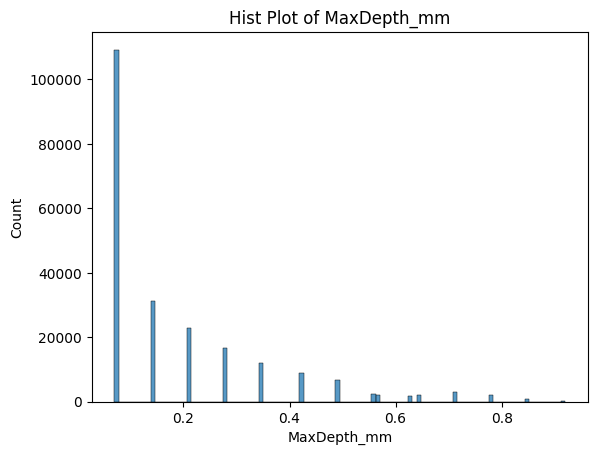

In [131]:
# class_counts = DPrev_Old_Filtered_Anomaly_mapped_df['MaxDepth_mm'].value_counts().sort_index()
sns.histplot(DPrev_Old_Filtered_Anomaly_mapped_df['MaxDepth_mm'], bins=100)
plt.title('Hist Plot of MaxDepth_mm')
plt.xlabel('MaxDepth_mm')
plt.ylabel('Count')
plt.show()

### Feature Importance

Lasso regularization algorithm is used for to identify feature importance.

#### Processing Features

In [137]:
# Define features and target
features = DPrev_Old_Filtered_Anomaly_mapped_df.drop(
    columns=[
        'MaxDepth_mm',
        'Tag',
        'ErrorClassification',
        'Prev_MaxDepth_mm',
        'DepthChange',
        'LengthChange',
        'WidthChange',
        'DistanceDiff',
        'OrientationDiff'
    ]
)

target = DPrev_Old_Filtered_Anomaly_mapped_df['MaxDepth_mm']

Standardization of features is done.
Data splitting into training and testing sets is done.
Grid search is done. Best alpha value: 0.001
Fitting the Lasso model with the best alpha is done.
Calculation of feature coefficients is done.


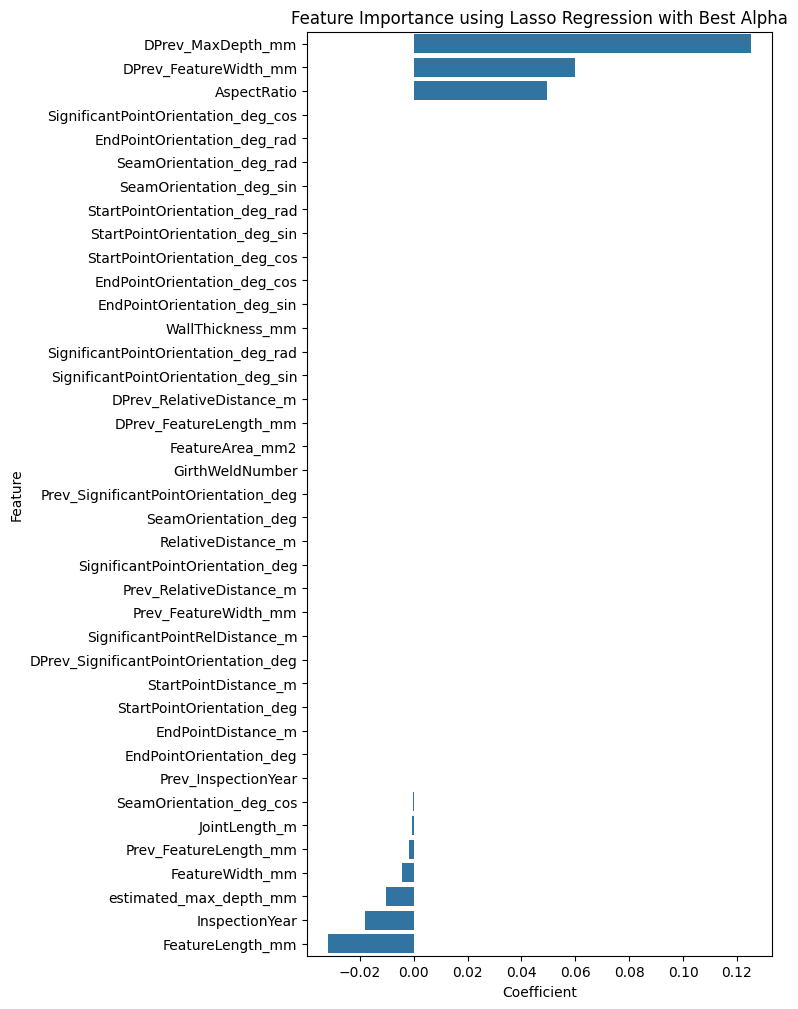

Plotting of coefficients is done.


In [138]:
from src.tools import FeatureImportance

feature_importance = FeatureImportance(features, target)

# Perform the steps
feature_importance.standardize_features()
feature_importance.split_data()
feature_importance.perform_grid_search()
feature_importance.fit_best_lasso()
feature_importance.calculate_coefficients()

# Plot the coefficients
feature_importance.plot_coefficients()

In [ ]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [ ]:
# Split the data into training and testing sets
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

In [ ]:
# Define the grid of alpha values to search
alpha_grid = {'alpha': np.linspace(0.001, 1, 100)} 

In [ ]:
# Define the Lasso model
lasso = Lasso()

In [ ]:
# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=lasso, param_grid=alpha_grid, cv=5, scoring='neg_mean_squared_error')

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train_lasso, y_train_lasso)

In [ ]:
# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha value: {best_alpha}")

In [ ]:
# Fit the Lasso model with the best alpha
best_lasso = Lasso(alpha=best_alpha)
best_lasso.fit(X_train_lasso, y_train_lasso)

In [ ]:
# Get the coefficients
coefficients = best_lasso.coef_

In [ ]:
# Create a DataFrame to store feature names and their coefficients
importance_df = pd.DataFrame({'Feature': features.columns, 'Coefficient': coefficients})
importance_df.sort_values(by='Coefficient', ascending=False, inplace=True)

In [ ]:
from src.tools import FeatureImportance

feature_importance = FeatureImportance(features, target)

# Perform the steps
feature_importance.standardize_features()
feature_importance.split_data()
feature_importance.perform_grid_search()
feature_importance.fit_best_lasso()
feature_importance.calculate_coefficients()

# Plot the coefficients
feature_importance.plot_coefficients()

KeyboardInterrupt: 

### Fitting Regressor Model

In [ ]:
# Apply the mask to remove outliers only from the target variable
target = DPrev_Old_Filtered_Anomaly_mapped_df['MaxDepth_mm']

# Keep all features, including rows where target is an outlier
features = DPrev_Old_Filtered_Anomaly_mapped_df[[
        'GirthWeldNumber',
        'InspectionYear',
        'RelativeDistance_m',
        'FeatureLength_mm',
        'FeatureWidth_mm',
        'SignificantPointOrientation_deg',
        'Prev_InspectionYear',
        'Prev_RelativeDistance_m',
        'Prev_FeatureLength_mm',
        'Prev_FeatureWidth_mm',
        'Prev_MaxDepth_mm',
        'Prev_SignificantPointOrientation_deg',
        'DPrev_RelativeDistance_m',
        'DPrev_FeatureLength_mm',
        'DPrev_FeatureWidth_mm',
        'DPrev_MaxDepth_mm',
        'DPrev_SignificantPointOrientation_deg',
        'AspectRatio',
        'FeatureArea_mm2',
        'estimated_max_depth_mm',
        'SignificantPointOrientation_deg_sin',
        'SignificantPointOrientation_deg_cos',
        'LengthChange',
        'WidthChange',
        'DistanceDiff',
        'OrientationDiff'
    ]]

# Ensure features and target have the same index
features = features.loc[target.index]

# Apply standard scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

**Addressing Class Imbalance**

In [ ]:
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from imblearn.under_sampling import RandomUnderSampler

# Original discretized values
original_discretized_values = np.unique(target)

# Bin the target variable
n_bins = len(original_discretized_values)  # 13 unique values
kbins = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
target_binned = kbins.fit_transform(target.values.reshape(-1, 1)).reshape(-1)

# Convert target_binned to integers
target_binned = target_binned.astype(int)

# Calculate the frequency of each bin
bin_counts = np.bincount(target_binned)

# Define the desired number of samples for each bin
median_freq = np.median(bin_counts)
sampling_strategy = {i: min(count, int(median_freq)) for i, count in enumerate(bin_counts) if count > 0}

# Apply Random Undersampling
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
features_resampled, target_resampled_binned = rus.fit_resample(features, target_binned)

# Map the binned target back to original discretized values
target_resampled = original_discretized_values[target_resampled_binned]

# Verify the resulting values match the original discretized values
print("Original discretized values:")
print(original_discretized_values)
print("Resulting values after resampling and mapping back:")
print(target_resampled)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(features_resampled, target_resampled, test_size=0.2, random_state=42)

In [ ]:
# Define the search space
search_spaces = {
    'learning_rate': Real(0.01, 0.5, prior='log-uniform'),
    'max_iter': Integer(100, 500),
    'max_depth': Integer(3, 10),
    'min_samples_leaf': Integer(5, 50),
    'l2_regularization': Real(1e-6, 1e-2, prior='log-uniform')
}

In [ ]:
# Initialize the base model
base_model = HistGradientBoostingRegressor(random_state=42)

In [ ]:
# Define the callback
delta_y_stopper = DeltaYStopper(delta=0.001)

In [ ]:
# Initialize BayesSearchCV
bayes_search = BayesSearchCV(
    base_model,
    search_spaces,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error')

In [ ]:
# Perform the search
bayes_search.fit(X_train[y_train.notnull()], y_train[y_train.notnull()], callback=[delta_y_stopper])

In [ ]:
best_params = bayes_search.best_params_
# Print the best parameters
print("Best parameters found:")
print(best_params)

In [ ]:
# Initialize the model with the best parameters
# best_model = HistGradientBoostingRegressor(
#     random_state=42,
#     **best_params
# )

best_model = HistGradientBoostingRegressor(
    l2_regularization=4.3693399475103194e-05,
    learning_rate=0.17233925413725915,
    max_depth=10,
    max_iter=226,
    min_samples_leaf=35,
    random_state=42
)

In [ ]:
# Perform the search
best_model.fit(X_train, y_train)

In [ ]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_true = y_test

# Evaluate the model
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
me = np.mean(y_true - y_pred)  # Mean Error


print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²) Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
print(f"Mean Error (ME): {me:.4f}")

**mapping**
- Root Mean Squared Error (RMSE): 0.0946
- Mean Absolute Error (MAE): 0.0607
- R-squared (R²) Score: 0.8994
- Mean Absolute Percentage Error (MAPE): 30.9938%
- Mean Error (ME): 0.0002

In [ ]:
# Assuming best_hgb_model is already fitted
# y_pred = best_model.predict(X_test)

# Create a DataFrame for easier plotting
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

In [ ]:
# Define a range of tolerance values
tolerances = np.arange(0.01, 0.51, 0.01)  # Tolerances from 1% to 30%

# Calculate prediction accuracy for each tolerance value
accuracies = []
for tolerance in tolerances:
    accuracy = np.mean(np.abs((y_test - y_pred) / y_test) < tolerance) * 100
    accuracies.append(accuracy)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(tolerances * 100, accuracies, marker='o')
plt.xlabel('Tolerance (%)')
plt.ylabel('Prediction Accuracy (%)')
plt.title('Prediction Accuracy for Different Tolerance Ranges')
plt.grid(True)
plt.show()

In [ ]:
# Violin plot
plt.figure(figsize=(15, 6))
sns.violinplot(x='Actual', y='Predicted', data=results)

plt.xlabel('Max Depth (mm)')
plt.ylabel('Predicted Max Depth (mm)')
plt.title('Actual vs Predicted Values')
plt.show()

In [ ]:
# Adding a scatter plot for better visual comparison
sns.scatterplot(x='Actual', y='Predicted', data=results, color='blue', alpha=0.5)

# Adding a diagonal line
min_val = min(results['Actual'].min(), results['Predicted'].min())
max_val = max(results['Actual'].max(), results['Predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.xlabel('Max Depth (mm)')
plt.ylabel('Predicted Max Depth (mm)')
plt.title('Actual vs Predicted Values')
plt.show()

I think I should compared the ml prediction against the estimated max depth to show the value of ml prediction
then I can use the previous width and length change for future change and predict the depth and find the performance for 7th year.

In [ ]:
# # Predict missing values
# AnomaliesProc_ML_Ready.loc[AnomaliesProc_ML_Ready['MaxDepth_mm'].isnull(), 'MaxDepth_mm_predicted'] = best_model.predict(scaler.transform(features[AnomaliesProc_ML_Ready['MaxDepth_mm'].isnull()]))

# # Check for remaining missing values
# missing_values_remaining = AnomaliesProc_ML_Ready['MaxDepth_mm'].isnull().sum()

# print(f"Number of remaining missing values in 'MaxDepth_mm': {missing_values_remaining}")

In [ ]:
# # Show only the records where the max depth is predicted
# predicted_records = AnomaliesProc_ML_Ready[AnomaliesProc_ML_Ready['MaxDepth_mm'].isnull()]
# print(predicted_records)

### Fitting ARIMAX Model

In [ ]:
Old_Filtered_Anomaly_mapped_df.columns

In [ ]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming your dataframe is called 'Old_Filtered_Anomaly_mapped_df'
# Ensure your dataframe does not have any missing values
Old_Filtered_Anomaly_mapped_df = Old_Filtered_Anomaly_mapped_df.dropna()

# Define the list of exogenous variables
exogenous_vars = [
    'GirthWeldNumber',
    'RelativeDistance_m',
    'FeatureLength_mm',
    'FeatureWidth_mm',
    'SignificantPointOrientation_deg',
    'Prev_InspectionYear',
    'Prev_RelativeDistance_m',
    'Prev_FeatureLength_mm',
    'Prev_FeatureWidth_mm',
    'Prev_MaxDepth_mm',
    'Prev_SignificantPointOrientation_deg',
    'AspectRatio',
    'FeatureArea_mm2',
    'estimated_max_depth_mm',
    'SignificantPointOrientation_deg_sin',
    'SignificantPointOrientation_deg_cos'
]

In [ ]:
# Extract features (exogenous variables) and target
features = Old_Filtered_Anomaly_mapped_df[exogenous_vars]
target = Old_Filtered_Anomaly_mapped_df['MaxDepth_mm']
time_series = Old_Filtered_Anomaly_mapped_df['InspectionYear']

In [ ]:
# Scale the exogenous variables
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets, ensuring temporal order is maintained
train_size = int(len(Old_Filtered_Anomaly_mapped_df) * 0.8)
X_train, X_test = features_scaled[:train_size], features_scaled[train_size:]
y_train, y_test = target[:train_size], target[train_size:]
time_train, time_test = time_series[:train_size], time_series[train_size:]

In [ ]:
# Fit the ARIMAX model using auto_arima for hyperparameter tuning
arimax_model = auto_arima(
    y=y_train,
    exogenous=X_train,
    seasonal=False,
    trace=True,
    error_action='ignore',  
    suppress_warnings=True,
    stepwise=True
)

# Print the summary of the best model found
print(arimax_model.summary())

In [ ]:
# Make predictions
predictions = arimax_model.predict(n_periods=len(y_test), exogenous=X_test)

# Evaluate the predictions
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

**mapping**
Root Mean Squared Error (RMSE): 0.0754
Mean Absolute Error (MAE): 0.0469
R-squared (R²) Score: 0.7848
Mean Absolute Percentage Error (MAPE): 29.9250%
Mean Error (ME): -0.0002

**No mapping**
Root Mean Squared Error (RMSE): 0.1551
Mean Absolute Error (MAE): 0.1112
R-squared (R²) Score: 0.6102
Mean Absolute Percentage Error (MAPE): 64.0431%
Mean Error (ME): 0.0001

### Predicting Anomaly Growth

In [ ]:
DPrev_Old_Filtered_Anomaly_mapped_df.columns

#### Additional Feature Engineering

In [ ]:
DPrev_Old_Filtered_Anomaly_mapped_df['Estimated_FeatureLength_mm'] = 2 * DPrev_Old_Filtered_Anomaly_mapped_df['Prev_FeatureLength_mm'] \
                                                                       - DPrev_Old_Filtered_Anomaly_mapped_df['DPrev_FeatureLength_mm']

DPrev_Old_Filtered_Anomaly_mapped_df['Estimated_FeatureWidth_mm'] = 2 * DPrev_Old_Filtered_Anomaly_mapped_df['Prev_FeatureWidth_mm'] \
                                                                        - DPrev_Old_Filtered_Anomaly_mapped_df['DPrev_FeatureWidth_mm']

DPrev_Old_Filtered_Anomaly_mapped_df['Powered_Prev_MaxDepth_mm'] = DPrev_Old_Filtered_Anomaly_mapped_df['Prev_MaxDepth_mm'] ** 2

In [ ]:
DPrev_Old_Filtered_Anomaly_mapped_df = DPrev_Old_Filtered_Anomaly_mapped_df.dropna()

#### Fitting the Regressor

In [ ]:
# Apply the mask to remove outliers only from the target variable
target = DPrev_Old_Filtered_Anomaly_mapped_df['MaxDepth_mm']

# Define the list of features
feature_columns = [
        'GirthWeldNumber',
        'InspectionYear',
        'RelativeDistance_m',
        'Estimated_FeatureLength_mm',
        'Estimated_FeatureWidth_mm',
        'SignificantPointOrientation_deg',
        'Prev_InspectionYear',
        'Prev_RelativeDistance_m',
        'Prev_FeatureLength_mm',
        'Prev_FeatureWidth_mm',
        'Prev_MaxDepth_mm',
        'Powered_Prev_MaxDepth_mm',
        'Prev_SignificantPointOrientation_deg',
        'DPrev_RelativeDistance_m',
        'DPrev_FeatureLength_mm',
        'DPrev_FeatureWidth_mm',
        'DPrev_MaxDepth_mm',
        'DPrev_SignificantPointOrientation_deg',
        'SignificantPointOrientation_deg_sin',
        'SignificantPointOrientation_deg_cos'
    ]

# Keep all features, including rows where target is an outlier
features = DPrev_Old_Filtered_Anomaly_mapped_df[feature_columns]

# Ensure features and target have the same index
features = features.loc[target.index]

# Apply standard scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

**Addressing Class Imbalance**

In [ ]:
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from imblearn.under_sampling import RandomUnderSampler

# Original discretized values
original_discretized_values = np.unique(target)

# Bin the target variable
n_bins = len(original_discretized_values)  # 13 unique values
kbins = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
target_binned = kbins.fit_transform(target.values.reshape(-1, 1)).reshape(-1)

# Convert target_binned to integers
target_binned = target_binned.astype(int)

# Calculate the frequency of each bin
bin_counts = np.bincount(target_binned)

# Define the desired number of samples for each bin
median_freq = np.median(bin_counts)
sampling_strategy = {i: min(count, int(median_freq)) for i, count in enumerate(bin_counts) if count > 0}

# Apply Random Undersampling
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
features_resampled, target_resampled_binned = rus.fit_resample(features, target_binned)

# Map the binned target back to original discretized values
target_resampled = original_discretized_values[target_resampled_binned]

# Verify the resulting values match the original discretized values
print("Original discretized values:")
print(original_discretized_values)
print("Resulting values after resampling and mapping back:")
print(np.unique(target_resampled))

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(features_resampled, target_resampled, test_size=0.2, random_state=42)

In [ ]:
# Define the search space
search_spaces = {
    'learning_rate': Real(0.01, 0.5, prior='log-uniform'),
    'max_iter': Integer(100, 500),
    'max_depth': Integer(3, 10),
    'min_samples_leaf': Integer(5, 50),
    'l2_regularization': Real(1e-6, 1e-2, prior='log-uniform')
}

In [ ]:
# Initialize the base model
base_model = HistGradientBoostingRegressor(random_state=42)

In [ ]:
# Define the callback
delta_y_stopper = DeltaYStopper(delta=0.001)

In [ ]:
# Initialize BayesSearchCV
bayes_search = BayesSearchCV(
    base_model,
    search_spaces,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error')

In [ ]:
# Perform the search
bayes_search.fit(X_train[y_train.notnull()], y_train[y_train.notnull()], callback=[delta_y_stopper])

In [ ]:
best_params = bayes_search.best_params_
# Print the best parameters
print("Best parameters found:")
print(best_params)

In [ ]:
# Initialize the model with the best parameters
# best_model = HistGradientBoostingRegressor(
#     random_state=42,
#     **best_params
# )

best_model = HistGradientBoostingRegressor(
    l2_regularization=0.0015783879853890563,
    learning_rate=0.055487920443684,
    max_depth=7,
    max_iter=386,
    min_samples_leaf=46,
    random_state=42
)

In [ ]:
# Perform the search
best_model.fit(X_train, y_train)

In [ ]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_true = y_test

# Evaluate the model
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
me = np.mean(y_true - y_pred)  # Mean Error


print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²) Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
print(f"Mean Error (ME): {me:.4f}")

**mapping**
Root Mean Squared Error (RMSE): 0.1090
Mean Absolute Error (MAE): 0.0729
R-squared (R²) Score: 0.7547
Mean Absolute Percentage Error (MAPE): 45.1916%
Mean Error (ME): -0.0002

In [ ]:
# Create a DataFrame for easier plotting
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

In [ ]:
# Define a range of tolerance values
tolerances = np.arange(0.01, 0.51, 0.01)  # Tolerances from 1% to 30%

# Calculate prediction accuracy for each tolerance value
accuracies = []
for tolerance in tolerances:
    accuracy = np.mean(np.abs((y_test - y_pred) / y_test) < tolerance) * 100
    accuracies.append(accuracy)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(tolerances * 100, accuracies, marker='o')
plt.xlabel('Tolerance (%)')
plt.ylabel('Prediction Accuracy (%)')
plt.title('Prediction Accuracy for Different Tolerance Ranges')
plt.grid(True)
plt.show()

In [ ]:
# Violin plot
plt.figure(figsize=(15, 6))
sns.violinplot(x='Actual', y='Predicted', data=results)

plt.xlabel('Max Depth (mm)')
plt.ylabel('Predicted Max Depth (mm)')
plt.title('Actual vs Predicted Values')
plt.show()

In [ ]:
# Adding a scatter plot for better visual comparison
sns.scatterplot(x='Actual', y='Predicted', data=results, color='blue', alpha=0.5)

# Adding a diagonal line
min_val = min(results['Actual'].min(), results['Predicted'].min())
max_val = max(results['Actual'].max(), results['Predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.xlabel('Max Depth (mm)')
plt.ylabel('Predicted Max Depth (mm)')
plt.title('Actual vs Predicted Values')
plt.show()

In [ ]:
# Initialize an empty list to store the results
results = []

# Loop through each unique 'GirthWeldNumber'
for weld_number in Old_Filtered_Anomaly_mapped_df['GirthWeldNumber'].unique():
    # Filter for the specific 'GirthWeldNumber' and 'InspectionYear' 7
    filtered_df = Old_Filtered_Anomaly_mapped_df[
        (Old_Filtered_Anomaly_mapped_df['GirthWeldNumber'] == weld_number) &
        (Old_Filtered_Anomaly_mapped_df['InspectionYear'] == 7)
    ]
    
    # Skip if no rows found
    if filtered_df.empty:
        continue
    
    # Define the target and features
    target = filtered_df['MaxDepth_mm']
    features = filtered_df[feature_columns]
    
    # Ensure features and target have the same index
    features = features.loc[target.index]
    
    # Apply standard scaling
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Predict the max depth
    predictions = best_model.predict(features_scaled)
    
    # Create a new dataframe with the predicted values
    prediction_df = filtered_df.copy()
    prediction_df['Predicted_MaxDepth_mm'] = predictions
    
    # Append the results to the list
    results.append(prediction_df)

# Concatenate all the results into a single dataframe
Anomaly_prediction_Year9 = pd.concat(results)


## Test

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint
from kerastuner.tuners import RandomSearch

# Assuming X_train and y_train are your input features and target variable

# Define the preprocessing steps
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Reshape input to be 3D [samples, time steps, features] for LSTM
X_train_reshaped = X_train_preprocessed.reshape((X_train_preprocessed.shape[0], 1, X_train_preprocessed.shape[1]))
X_test_reshaped = X_test_preprocessed.reshape((X_test_preprocessed.shape[0], 1, X_test_preprocessed.shape[1]))

# Define the model-building function
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   activation='relu',
                   input_shape=(1, X_train_reshaped.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='mse')
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=3,
    directory='my_dir',
    project_name='lstm_tuning'
)

# Perform the search
tuner.search(X_train_reshaped, y_train, epochs=100, validation_split=0.2)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model
best_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Make predictions
y_pred = best_model.predict(X_test_reshaped).flatten()
y_true = y_test

# Evaluate the model
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
me = np.mean(y_true - y_pred)  # Mean Error

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²) Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
print(f"Mean Error (ME): {me:.4f}")

**Hist Results**
Root Mean Squared Error (RMSE): 0.1090
Mean Absolute Error (MAE): 0.0729
R-squared (R²) Score: 0.7547
Mean Absolute Percentage Error (MAPE): 45.1916%
Mean Error (ME): -0.0002